# Training with synthetic data when the scaling function has two arguments

Here we show training with the synthetic data for two examples where the scaling function has two arguments.
The first example is a virtual synthetic system. The second example is the experiment of dynamical impact of a solid sphere on a Zener viscoelastic board.

# Example 1: synthetic system

In this example, we consider a virtual synthetic system, where perform training with the data generated by the function "gen_data_two_var_synthitic" and output the parameters.

The function "gen_data_two_var_synthetic" has two arguments.
The first argument is data_size.
The second one is noize_strength.

### Main module

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class NNfuncfit_two_var_synthetic(nn.Module):
    def __init__(self):
        super(NNfuncfit_two_var_synthetic, self).__init__()
        self.layerin=nn.Linear(4, 2)
        self.layer1=nn.Linear(2,100)
        self.layer2=nn.Linear(100,100)
        self.layer3= nn.Linear(100,100)
        self.layer4=nn.Linear(100,100)
        self.layerout=nn.Linear(100,1)

    def forward(self, x):
        x = self.layerin(x)
        x = F.relu(x)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = self.layerout(x)
        return x

def gen_data_two_var_synthetic(data_size,noise_strength=0.):
    x = torch.rand(data_size,4)
    X = x[:,0] * x[:,1] * x[:,2]
    Y = x[:,0]**2 * x[:,3]
    t = (1+X+X**2) * torch.exp(Y)
    dx = torch.normal(mean=torch.zeros(x.shape), std=torch.abs(x))*noise_strength
    dt = torch.normal(mean=torch.zeros(t.shape), std=torch.abs(t))*noise_strength
    x, t = x + dx, t + dt
    x, t = torch.log(x), torch.reshape(torch.log(t),(len(t),1))
    return x,t

def gen_data_grid(data_size,noise_strength=0.):
    ll = [0.0001+float(i)/data_size for i in range(data_size)]
    x = torch.transpose(torch.Tensor([ll,ll,ll,ll]),0,1)
    X = x[:,0] * x[:,1] * x[:,2]
    Y = x[:,0]**2 * x[:,3]
    t = (1.+X+X**2) * torch.exp(Y)
    x, t = torch.log(x), torch.reshape(torch.log(t),(len(t),1))
    return x,t

def single_learning_part_two_var_synthetic(max_epoch, loss_threshold, x_data, z_data, name='surface_plot', lr=0.1):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = NNfuncfit_two_var_synthetic().to(device)
    criterion = nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr )
    x, z = x_data.to(device), z_data.to(device)
    loss_values=[]
    for count in range(5):
        for epoch in range(max_epoch):
            y = model(x)
            loss = criterion(y , z)
            loss_values.append(loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
        if loss_values[-1] < loss_threshold:
            break
        else:
            print('too large loss ,{}times'.format(count+1))

    #loss
    print(loss_values[0],'->',loss_values[int(len(loss_values)/2)],'->',loss_values[-1])

    #result
    params1, params2 = list(model.parameters())[0][0], list(model.parameters())[0][1]
    params1, params2 = params1.cpu().detach().numpy(), params2.cpu().detach().numpy()
    params1, params2 = normalize_synthetic(params1,params2)
    print('params1 : {}, params2 : {}'.format(params1,params2))
    print('answer :{},{}'.format([1,1,1,0], [1,0,0,1/2]))

    result_Plot3d_surface_two_var_synthetic(model, x_data, z_data, device, name)

    return params1, params2

def extract_normalized_params(model):
    w1 = list(model.parameters())[0][0]
    w2 = list(model.parameters())[0][1]
    w1, w2 = normalize_synthetic(w1,w2)
    return w1.to('cpu').detach().numpy(), w2.to('cpu').detach().numpy()

def result_Plot3d_surface_two_var_synthetic(model, x_data, z_data, device, name):
    x_data_grid, z_data_grid = gen_data_grid(300)
    z_data = z_data.cpu().detach().numpy()
    params1, params2 = extract_normalized_params(model)

    hor_vals_1 = np.array([ np.dot(params1,x) for x in x_data])
    hor_vals_2 = np.array([ np.dot(params2,x) for x in x_data])

    hor_vals_grid_1 = np.array([ np.dot(params1,x) for x in x_data_grid])
    hor_vals_grid_2 = np.array([ np.dot(params2,x) for x in x_data_grid])
    Hor_vals_grid_1, Hor_vals_grid_2 = np.meshgrid(hor_vals_grid_1,hor_vals_grid_2)

    # genrate z value on each grid point
    zeros_mat = np.zeros((300,300))
    grid_matrix_x = np.stack((zeros_mat,zeros_mat,Hor_vals_grid_1,0.5*Hor_vals_grid_2),axis=2)
    z_nn_grid = model(torch.Tensor(grid_matrix_x).to(device)).cpu().detach().numpy()
    z_nn_grid = np.reshape(z_nn_grid,(300,300))

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111,projection='3d')

    # plot training data
    ax.scatter(hor_vals_1, hor_vals_2, z_data, label='Training data', color='black', marker="o", s=30)
    # draw learnig data by NN
    ax.plot_surface(Hor_vals_grid_1, Hor_vals_grid_2, z_nn_grid ,color='cornflowerblue',alpha=0.6)

    ax.set_xlabel(r"$X$", labelpad=5, size = "xx-large")
    ax.set_ylabel(r"$Y$", labelpad=5, size = "xx-large")
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r"$\psi$", labelpad=5, size = "xx-large")
    plt.legend(fontsize = 12, fancybox=False, bbox_to_anchor=(0.82, 0.75), edgecolor="black",
    borderpad=0.5, borderaxespad=0, handlelength=2, handletextpad=1)
    ax.view_init(elev=10, azim=190)
    ax.grid(False)
    ax.xaxis._axinfo['tick']['inward_factor']=0
    ax.yaxis._axinfo['tick']['inward_factor']=0
    ax.zaxis._axinfo['tick']['inward_factor']=0
    ax.xaxis.set_tick_params(pad=-3)
    ax.yaxis.set_tick_params(pad=-3)
    print('\n figure name : '+name+'.pdf')
    plt.savefig(name+".pdf")
    plt.tight_layout()
    plt.show()

def bootstrap_sample(x_data, z_data, sample_size):
    indices = np.random.choice(len(x_data), size=sample_size, replace=True)
    x_sample = x_data[indices]
    z_sample = z_data[indices]
    return x_sample, z_sample

def bootstrap_learning_part_two_var_synthetic(max_epoch, sample_num, loss_threshold, x_data, z_data, lr=0.1):
    params1, params2, plot = [], [], []
    count, loss_count = 0, 0
    while sample_num>count:
        l=[]
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = NNfuncfit_two_var_synthetic().to(device)
        criterion = nn.MSELoss()
        opt = torch.optim.SGD(model.parameters(), lr )
        x, z = bootstrap_sample(x_data, z_data, int(len(x_data)))#(1)
        x, z = x.to(device), z.to(device)
        for epoch in range(max_epoch):
            y = model(x)
            loss = criterion(y , z)
            l.append(loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
        if l[-1]>loss_threshold:
            loss_count += 1
            print('too large loss')
            if loss_count ==int(sample_num/2):
                print(loss_count,'loss count')
            continue

        count += 1

        if loss_count == int(sample_num):
            print('can not learn, stop the program')
        elif count==int(sample_num/2):
            print(count,'loop')
        elif count==sample_num:
            print(count,'loop')

        loss_values = l
        w1 = list(model.parameters())[0][0]
        w2 = list(model.parameters())[0][1]
        params1.append(w1)
        params2.append(w2)
        plot.append(plt.plot(loss_values))

    for i in range(count):
        params1[i], params2[i] = normalize_synthetic(params1[i],params2[i])

    error1 = error_solve(params1)
    error2 = error_solve(params2)
    print('\n error : {}, {}'.format(error1,error2))
    print( '\n loss figure')
    plt.show()

    return error1, error2

def normalize_synthetic(vec1, vec2):
    vec1 = vec1 - (vec1[-1]/vec2[-1] )*vec2
    vec1 = vec1/vec1[0]
    vec2 = vec2 - (vec2[1]/vec1[1])*vec1
    vec2 = vec2/vec2[0]
    return vec1, vec2

def error_solve(params):
    params = torch.stack(params).to('cpu').detach().numpy().copy()
    error = np.std(params,axis=0)
    return error

def params_plot(params,error,ans,noise_strength, name='prams_plot'):
    params, error = np.array(params).T, np.array(error).T

    fig = plt.figure(figsize=(18,12))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax_list = [ax1,ax2,ax3,ax4]

    for i in range(len(params)):
        para_vals, error_vals = params[i], error[i]
        name = 'components of the {}th vectors'.format(i+1)

        ax_list[i].hlines([ans[i]],0,0.25)
        ax_list[i].errorbar(noise_strength, para_vals, yerr=error_vals, capsize=3,label=name, fmt='o', ecolor='k', ms=7, mfc='None', mec='k')
        ax_list[i].set_xlabel('errror pecentage')
        ax_list[i].set_ylabel('components of the {}th vector'.format(i))
        ax_list[i].legend(fontsize = 12, fancybox=False, edgecolor="black", borderpad=0.5, borderaxespad=0.8, handlelength=2, handletextpad=1)
    plt.tick_params(direction = "in", right=True, top=True, labelsize = 15)
    plt.tight_layout()
    plt.savefig(name+'.pdf')
    print('figure name : '+name+'.pdf')
    plt.show()

## Training with the synthetic data

Generate synthetic data with various noise strengths and train the neural network. The uncertainty of the trained parameters is estimated by the bootstrapping method.

*need to determine "loss_threthold"

In [ ]:
data_size= 1000
max_epoch = 20000
sample_num=50
X_data,T_data = gen_data_two_var_synthetic(data_size)
loss_threshold=0.0015
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size,noise_strength=0.025)
loss_threshold=0.15
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size,noise_strength=0.05)
loss_threshold=0.15
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size,noise_strength=0.075)
loss_threshold=0.15
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size,noise_strength=0.10)
loss_threshold=0.15
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size,noise_strength=0.125)
loss_threshold=0.15
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size,noise_strength=0.15)
loss_threshold=0.15
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size,noise_strength=0.175)
loss_threshold=0.15
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size,noise_strength=0.20)
loss_threshold=0.15
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, lr=0.1)

### Plot the loss values as a function of noize strength


In [ ]:
# input the loss data and noise strength
loss_list = []
r = []

res1 = np.polyfit(r, loss_list, 1)
res2 = np.polyfit(r, loss_list, 2)
res3 = np.polyfit(r, loss_list, 3)

y1 = np.poly1d(res1)(r) #linear
y2 = np.poly1d(res2)(r) #quadratic
y3 = np.poly1d(res3)(r) #cubic

diff1 = np.std(y1 - loss_list)
diff2 = np.std(y2 - loss_list)
diff3 = np.std(y3 - loss_list)
print(diff1)
print(diff2)
print(diff3)
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(2, 2, 1)
ax.set_xlabel('$r$',size = "xx-large")
ax.set_ylabel('loss',labelpad=20,size = "xx-large",rotation='horizontal')
plt.tick_params(direction = "in", right=True, top=True, labelsize = 15)
plt.tight_layout()


ax.scatter(r, loss_list, label='original')
ax.plot(r, y2, ':', label='quadratic',c='black')
plt.savefig('loss_plot.pdf')
plt.show()

## Estimation of the uncertainity to the learned parameters by bootstrap method

In [ ]:
l_params1, l_params2 = [], []
l_error1, l_error2 = [], []
def append_params(params1,params2,error1,error2):
    l_params1.append(params1)
    l_params2.append(params2)
    l_error1.append(error1)
    l_error2.append(error2)
data_size= 1000
max_epoch = 20000
sample_num=50

### noise strength = 0

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size)
loss_threshold=0.0015
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, string='surface_plot_0', lr=0.1)
error1, error2 = bootstrap_learning_part_two_var_synthetic(max_epoch, sample_num, loss_threshold, X_data, T_data, lr=0.1)
append_params(params1,params2,error1,error2)

### noise strength = 0.05

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size, noise_strength=0.05)
loss_threshold=0.0042
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, string='surface_plot_5', lr=0.1)
error1, error2 = bootstrap_learning_part_two_var_synthetic(max_epoch, sample_num, loss_threshold, X_data, T_data, lr=0.1)
append_params(params1,params2,error1,error2)

### noise strength = 0.10

In [ ]:
X_data,T_data = gen_data_two_var_synthetic(data_size, noise_strength=0.10)
loss_threshold=0.0145
params1, params2 = single_learning_part_two_var_synthetic(max_epoch, loss_threshold, X_data, T_data, string='surface_plot_10', lr=0.1)
error1, error2 = bootstrap_learning_part_two_var_synthetic(max_epoch, sample_num, loss_threshold, X_data, T_data, lr=0.1)
append_params(params1,params2,error1,error2)

### error value

In [ ]:
noise_strength_list=[]
ans1 = [1,1,1,0]
ans2 = [1,0,0,1/2]
for i in range(len(l_params1)):
    noise_strength_list.append(i*5)
print(noise_strength_list)
params_plot(params1,error1,ans1,noise_strength_list)
params_plot(params2,error2,ans1,noise_strength_list)

# Example 2: the Zener viscoelastic model

We perform training with two sets of synthetic data.


### Load the data generated respecting the constraints of the actual experiment

In [ ]:
import pandas as pd
import torch
import numpy as np

df = pd.read_table("two_var_data_set.txt")
pd.set_option('display.max_columns', 50)
df=df.dropna(axis=1)

df['Pi'] = df.loc[:,'delta']/df.loc[:,'R']
df['eta'] = df.loc[:,'rho']*df.loc[:,'vi']**2/df.loc[:,'E']
df['kappa']=df.loc[:,'h']/(df.loc[:,'R'])
df['theta'] = df.loc[:,'mu']/df.loc[:,'E']**(0.5)/df.loc[:,'rho']**(0.5)/(df.loc[:,'R'])
df['nu'] = df.loc[:,'E']/df.loc[:,'EK']

# 2nd kind
df['Psi'] = df.loc[:,'Pi']**(3)/(df.loc[:,'eta']*df.loc[:,'kappa'])
df['Zeta'] = df.loc[:,'Pi']/df.loc[:,'theta']/df.loc[:,'eta']**0.5
df['ZetaK'] = df.loc[:,'Pi']/df.loc[:,'theta']/df.loc[:,'eta']**0.5/df.loc[:,'nu']

# convert to log
log_Pi = np.log(df['Pi']).to_numpy()
log_kappa = np.log(df['kappa']).to_numpy()
log_theta = np.log(df['theta']).to_numpy()
log_eta = np.log(df['eta']).to_numpy()
log_nu = np.log(df['nu']).to_numpy()

log_Psi = np.log( df['Psi'] ).to_numpy()

# convert to Torch
experimental_x = torch.Tensor( np.transpose( np.array([log_Pi, log_eta, log_theta, log_nu ]) ))
experimental_t = torch.reshape(torch.Tensor( log_Psi ),(len(torch.Tensor( log_Psi )),1))

### Main module

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class NNfuncfit_two_var_Zener(nn.Module):
    def __init__(self):
        super(NNfuncfit_two_var_Zener, self).__init__()
        self.layerin=nn.Linear(4, 2)
        self.layer1=nn.Linear(2,100)
        self.layer2=nn.Linear(100,100)
        self.layer3= nn.Linear(100,100)
        self.layer4=nn.Linear(100,100)
        self.layerout=nn.Linear(100,1)

    def forward(self, x):
        x = self.layerin(x)
        x = F.relu(x)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = self.layerout(x)
        return x

def gen_data_Zener(data_size,noise_strength=0.):
    # Pi, Eta, Theta, Nu
    x = torch.rand(data_size, 4)
    Z = x[:,0] * (x[:,2]**(-1)) * x[:,1]**(-1/2)
    Z_K = x[:,0] * (x[:,2]**(-1)) * (x[:,1]**(-1/2)) * x[:,3]**(-1)
    Psi = 2*Z/(Z_K + 3* (1-np.exp(-Z)))
    kappa = (x[:,0]**(3)) * (x[:,1]**(-1) )* (Psi**(-1))
    t = x[:,0]**3/(kappa * x[:,1])
    dx = torch.normal(mean=torch.zeros(x.shape), std=torch.abs(x))*noise_strength
    dt = torch.normal(mean=torch.zeros(t.shape), std=torch.abs(t))*noise_strength
    x, t = x + dx, t + dt
    x, t = torch.log(x), torch.reshape(torch.log(t),(len(t),1))
    return x, t

def gen_data_grid_for_synthetic(data_size,noise_strength=0.):
    ll = [0.0001+float(i)/data_size for i in range(data_size)]
    x = torch.transpose(torch.Tensor([ll,ll,ll,ll]),0,1)
    Z = x[:,0] * (x[:,2]**(-1)) * x[:,1]**(-1/2)
    Z_K = x[:,0] * (x[:,2]**(-1)) * (x[:,1]**(-1/2)) * x[:,3]**(-1)
    Psi = 2*Z/(Z_K + 3* (1-np.exp(-Z)))
    x, t = torch.log(x), torch.reshape(torch.log(Psi),(len(Psi),1))
    return x,t

def gen_data_grid_for_experimetal(data_size):
    x0=np.linspace(0.9*np.min(log_Pi), 1.1*np.max(log_Pi), data_size)
    x1=np.linspace(0.9*np.min(log_eta), 1.1*np.max(log_eta), data_size)
    x2=np.linspace(0.9*np.min(log_theta), 1.1*np.max(log_theta), data_size)
    x3=np.linspace(0.9*np.min(log_nu), 1.1*np.max(log_nu), data_size)
    x = np.array([x0,x1,x2,x3])
    x = torch.transpose(torch.Tensor(x),0,1)
    Z = torch.exp(x[:,0]) * (torch.exp(x[:,2])**(-1)) * torch.exp(x[:,1])**(-1/2)
    Z_K = torch.exp(x[:,0]) * (torch.exp(x[:,2])**(-1)) * (torch.exp(x[:,1])**(-1/2)) * torch.exp(x[:,3])**(-1)
    Psi = 2*Z/(Z_K + 3* (1-np.exp(-Z)))
    t = torch.reshape(torch.log(Psi),(len(Psi),1))
    return x, t

def single_learning_part_two_var_Zener(max_epoch, loss_threshold, x_data, z_data, data_type=0, name='surface_plot_Zener', lr=0.1):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = NNfuncfit_two_var_Zener().to(device)
    criterion = nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr )
    x, z = x_data.to(device), z_data.to(device)
    loss_values=[]
    for count in range(5):
        for epoch in range(max_epoch):
            y = model(x)
            loss = criterion(y , z)
            loss_values.append(loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
        if loss_values[-1] < loss_threshold:
            break
        else:
            print('too large loss ,{}times'.format(count+1))

    #loss
    print(loss_values[0],'->',loss_values[int(len(loss_values)/2)],'->',loss_values[-1])

    #result
    params1, params2 = list(model.parameters())[0][0], list(model.parameters())[0][1]
    params1, params2 = params1.cpu().detach().numpy(), params2.cpu().detach().numpy()
    params1, params2 = normalize_Zener(params1,params2)
    print('- normalize ->')
    print('params1 : {}, params2 : {}'.format(params1,params2))
    print('answer :{},{}'.format([1,-1/2,-1,0], [0 ,0 ,0 ,1]))

    result_Plot3d_surface_Zener(model, x_data, z_data, device, data_type, name)

    return params1, params2

def extract_normalized_params(model):
    w1 = list(model.parameters())[0][0]
    w2 = list(model.parameters())[0][1]
    w1, w2 = normalize_Zener(w1,w2)
    return w1.to('cpu').detach().numpy(), w2.to('cpu').detach().numpy()

def result_Plot3d_surface_Zener(model, x_data, z_data, device, data_type, name):
    if data_type == 0:
        x_data_grid, z_data_grid = gen_data_grid_for_synthetic(300)
    else:
        x_data_grid, z_data_grid = gen_data_grid_for_experimetal(300)

    z_data = z_data.cpu().detach().numpy()

    params1, params2 = extract_normalized_params(model)

    hor_vals_1 = np.array([ np.dot(params1,x) for x in x_data])
    hor_vals_2 = np.array([ np.dot(params2,x) for x in x_data])

    hor_vals_grid_1 = np.array([ np.dot(params1,x) for x in x_data_grid])
    hor_vals_grid_2 = np.array([ np.dot(params2,x) for x in x_data_grid])
    Hor_vals_grid_1, Hor_vals_grid_2 = np.meshgrid(hor_vals_grid_1, hor_vals_grid_2)

    # generate z value on each grid point(see the explanation below)
    zeros_mat = np.zeros((300,300))
    grid_matrix_x = np.stack((Hor_vals_grid_1,zeros_mat,zeros_mat,Hor_vals_grid_2),axis=2)
    z_nn_grid = model(torch.Tensor(grid_matrix_x).to(device)).cpu().detach().numpy()
    z_nn_grid = np.reshape(z_nn_grid,(300,300))

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111,projection='3d')

    ax.scatter(hor_vals_1, hor_vals_2, z_data, label='Training data', color='black', marker="o", s=30)
    ax.plot_surface(Hor_vals_grid_1, Hor_vals_grid_2, z_nn_grid ,color='cornflowerblue',alpha=0.6)

    ax.set_xlabel(r"$\log Z$", labelpad=5, size = "xx-large")
    ax.set_ylabel(r"$\log \nu$", labelpad=5, size = "xx-large")
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(r"$\psi$", labelpad=5, size = "xx-large", rotation = "horizontal")
    plt.legend(fontsize = 12, fancybox=False, bbox_to_anchor=(0.82, 0.75), edgecolor="black", borderpad=0.5, borderaxespad=0.8, handlelength=2, handletextpad=1)
    ax.view_init(elev=10, azim=190)
    ax.grid(False)
    ax.xaxis._axinfo['tick']['inward_factor']=0
    ax.yaxis._axinfo['tick']['inward_factor']=0
    ax.zaxis._axinfo['tick']['inward_factor']=0
    ax.xaxis.set_tick_params(pad=-3)
    ax.yaxis.set_tick_params(pad=-3)
    print('\n figure name : '+name+'.pdf')
    plt.savefig(name+".pdf")
    plt.tight_layout()
    plt.show()

def bootstrap_sample(x_data, z_data, sample_size):
    indices = np.random.choice(len(x_data), size=sample_size, replace=True)
    x_sample = x_data[indices]
    z_sample = z_data[indices]
    return x_sample, z_sample

def normalize_Zener(vec1, vec2):
    vec1 = vec1 - (vec1[-1]/vec2[-1] )*vec2
    vec1 = vec1/vec1[0]
    vec2 = vec2 - (vec2[0]/vec1[0])*vec1
    vec2 = vec2/vec2[-1]
    return vec1, vec2

def error_solve(params):
    params = torch.stack(params).to('cpu').detach().numpy().copy()
    error = np.std(params,axis=0)
    return error

def bootstrap_learning_part_two_var_Zener(max_epoch, sample_num, loss_threshold, x_data, z_data, lr=0.1):
    params1, params2, plot = [], [], []
    count, loss_count = 0, 0
    while sample_num>count:
        l=[]
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = NNfuncfit_two_var_Zener().to(device)
        criterion = nn.MSELoss()
        opt = torch.optim.SGD(model.parameters(), lr )
        x, z = bootstrap_sample(x_data, z_data, int(len(x_data)))#(1)
        x, z = x.to(device), z.to(device)
        for epoch in range(max_epoch):
            y = model(x)
            loss = criterion(y , z)
            l.append(loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
        if l[-1]>loss_threshold:
            loss_count += 1
            print('too large loss')
            if loss_count ==int(sample_num/2):
                print(loss_count,'loss count')
            continue

        count += 1

        if loss_count == int(sample_num):
            print('can not learn, stop the program')
        elif count==int(sample_num/2):
            print(count,'loop')
        elif count==sample_num:
            print(count,'loop')

        loss_values = l
        w1 = list(model.parameters())[0][0]
        w2 = list(model.parameters())[0][1]
        params1.append(w1)
        params2.append(w2)
        plot.append(plt.plot(loss_values))

    for i in range(count):
        params1[i], params2[i] = normalize_Zener(params1[i],params2[i])

    error1 = error_solve(params1)
    error2 = error_solve(params2)
    print('\n error : {}, {}'.format(error1,error2))
    print( '\n loss figure')
    plt.show()

    return error1, error2

### About drawing the surface

To draw the surface of the trained Neural Network, the $z_{nn}$ values at each grid point on the generated grid are required. Therefore, $\vec{x}$ satisfying the following equation is necessary:
$$\text{hor_val_1} = \vec{x}\cdot \vec{p_1} \ ,\\
\text{hor_val_2} = \vec{x}\cdot \vec{p_2} \ .$$
The degree of freedom of $\vec{x}$ is 4, but only two equations are given. Therefore, it is necessary to manually impose conditions. For simplicity, $x_1$ and $x_2$ are set to 0. Then, $x_0$ is set to hor_val_1(0) and $x_3$ is set to hor_val_2(3) (this is guaranteed by the normalization taken in our case). In this way, values of x are provided for each grid point.

## Traning with the first data set

Estimate the parameters by training the neural network and introduce the uncertainties by the bootstrap method

1.6474214792251587 -> 0.00013087427942082286 -> 4.988574073649943e-05
- normalize ->
params1 : [ 1.         -0.49925354 -1.0145661   0.        ], params2 : [-0.0000000e+00  2.6013175e-04  6.0933707e-03  1.0000000e+00]
answer :[1, -0.5, -1, 0],[0, 0, 0, 1]

 figure name : surface_plot_Zener_synthetic.pdf


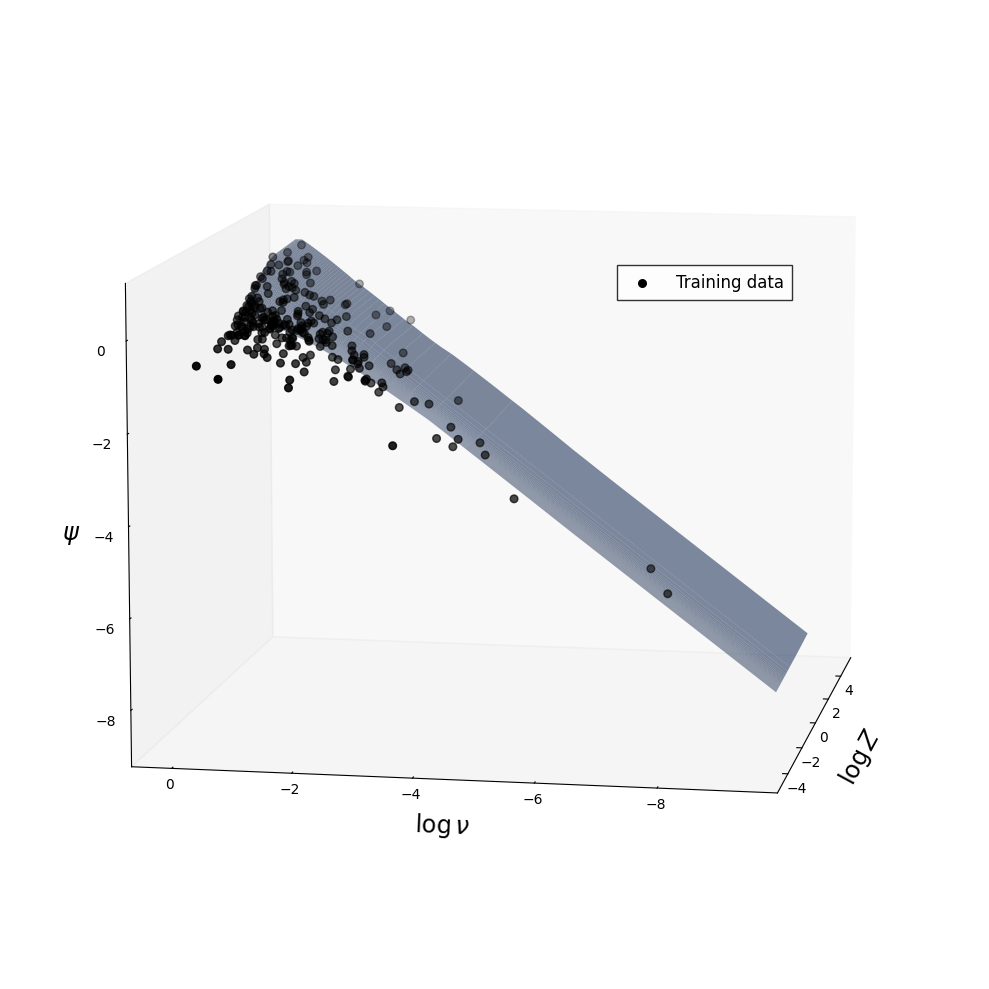

In [ ]:
max_epoch = 20000
X_data,T_data = gen_data_Zener(250)
loss_threshold=0.00007
params1, params2 = single_learning_part_two_var_Zener(max_epoch, loss_threshold, X_data, T_data, name='surface_plot_Zener_synthetic',  lr=0.1)

In [ ]:
sample_num =50
loss_threshold=0.00007
error1, error2 = bootstrap_learning_part_two_var_Zener(max_epoch, sample_num, loss_threshold, X_data, T_data, lr=0.1)

## Training with the second data set

Below is the training with the second data set, which is generated so that it respects the constraints of the actual experiment.

Estimate the parameters by training the neural network and introduce the uncertainties by the bootstrap method

Attention: The variable "data_type" in "single_learning_part" represents the type of surface being plotted, where the default value of "0" corresponds to surfaces drawn for synthetic data, and "1" corresponds to surfaces drawn for experimental data.

0.21404747664928436 -> 0.00011656497372314334 -> 2.1435835151351057e-05
- normalize ->
params1 : [ 1.        -0.5188967 -1.0896227  0.       ], params2 : [0.         0.04707516 0.22822659 1.        ]
answer :[1, -0.5, -1, 0],[0, 0, 0, 1]

 figure name : surface_plot_Zener_experimental.pdf


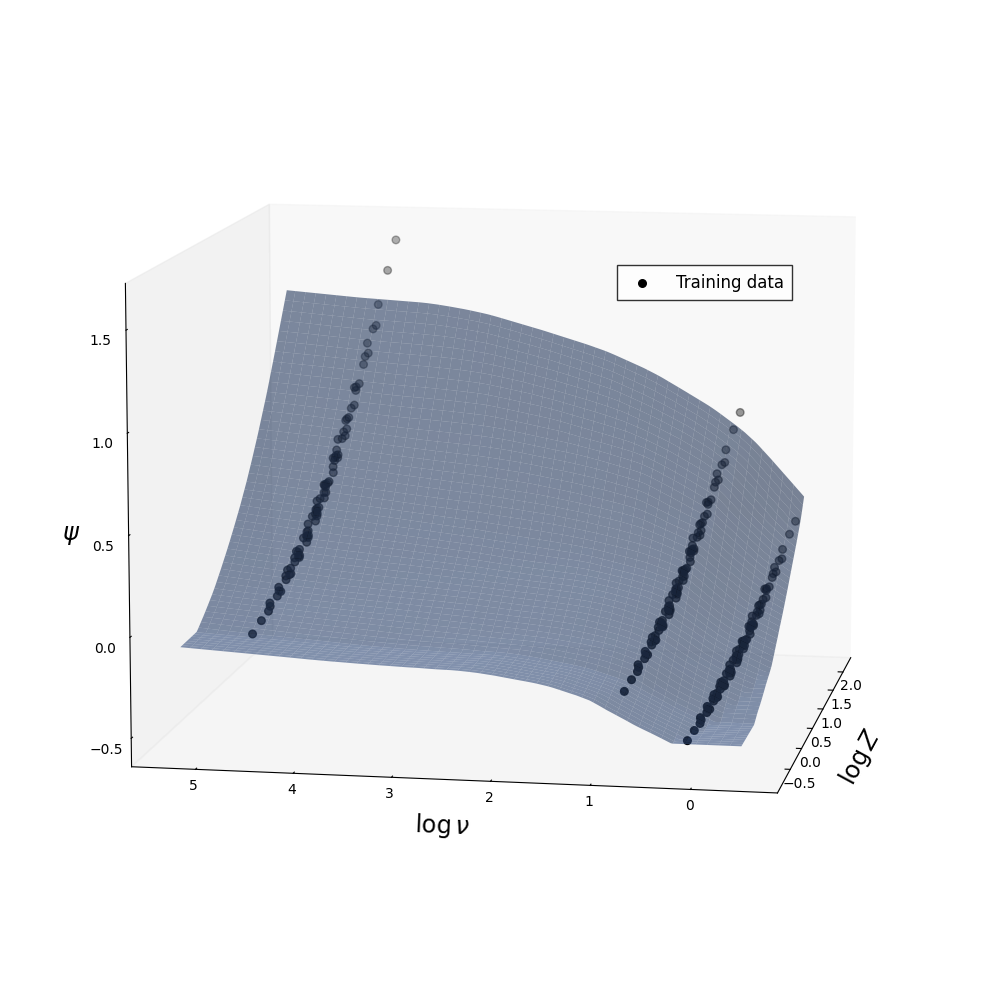

In [ ]:
max_epoch = 20000
X_data,T_data = experimental_x,experimental_t
loss_threshold=0.00007
params1, params2 = single_learning_part_two_var_Zener(max_epoch, loss_threshold, X_data, T_data, data_type=1, name='surface_plot_Zener_experimental',  lr=0.1)